In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("dark")

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from scipy.stats.mstats import winsorize
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split

from tqdm import tqdm

ModuleNotFoundError: No module named 'numpy'

In [147]:
# Constants

CMAP = "YlGnBu"
TARGET = "income"
BATCH_SIZE = 50

In [148]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X_base = adult.data.features 
y_base = adult.data.targets 

In [149]:
X = X_base.copy()
y = y_base.copy()

### dataset analysis

Link: http://archive.ics.uci.edu/dataset/2/adult

In [150]:
print(f"Dataset size: {X.shape[0]}")
print("Example:")
X.head()

Dataset size: 48842
Example:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [151]:
numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
total_features = list(X.columns)

In [152]:
# Let's check X integrity
# Change all strange values in 
# categoricaal columns to null

print(X.isna().sum())

# as we can see, column 'workclass', 'occupation', 'native-country' have NaN values

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
dtype: int64


In [153]:
# target column has only two values
# so, it's Rregression task

print("Target column values:")
print(*y['income'].drop_duplicates().values)

# let's drop point
y['income'] = y['income'].apply(lambda x: x.replace(".", ""))
print("Target column values corrected:")
print(*y['income'].drop_duplicates().values)

Target column values:
<=50K >50K <=50K. >50K.
Target column values corrected:
<=50K >50K


In [154]:
####################
### Task:
#####################
# Prediction task is to determine whether a person makes over 50K a year.
# Features:
### Numerical: age, fnlwgt, education-num, capital-gain, capital-loss, hours-per-week
### Categorical: workclass, education, marital-status, occupation, relationship, race, sex, native-country

### Data Visualization
#### Source: https://en.wikipedia.org/wiki/Quartile

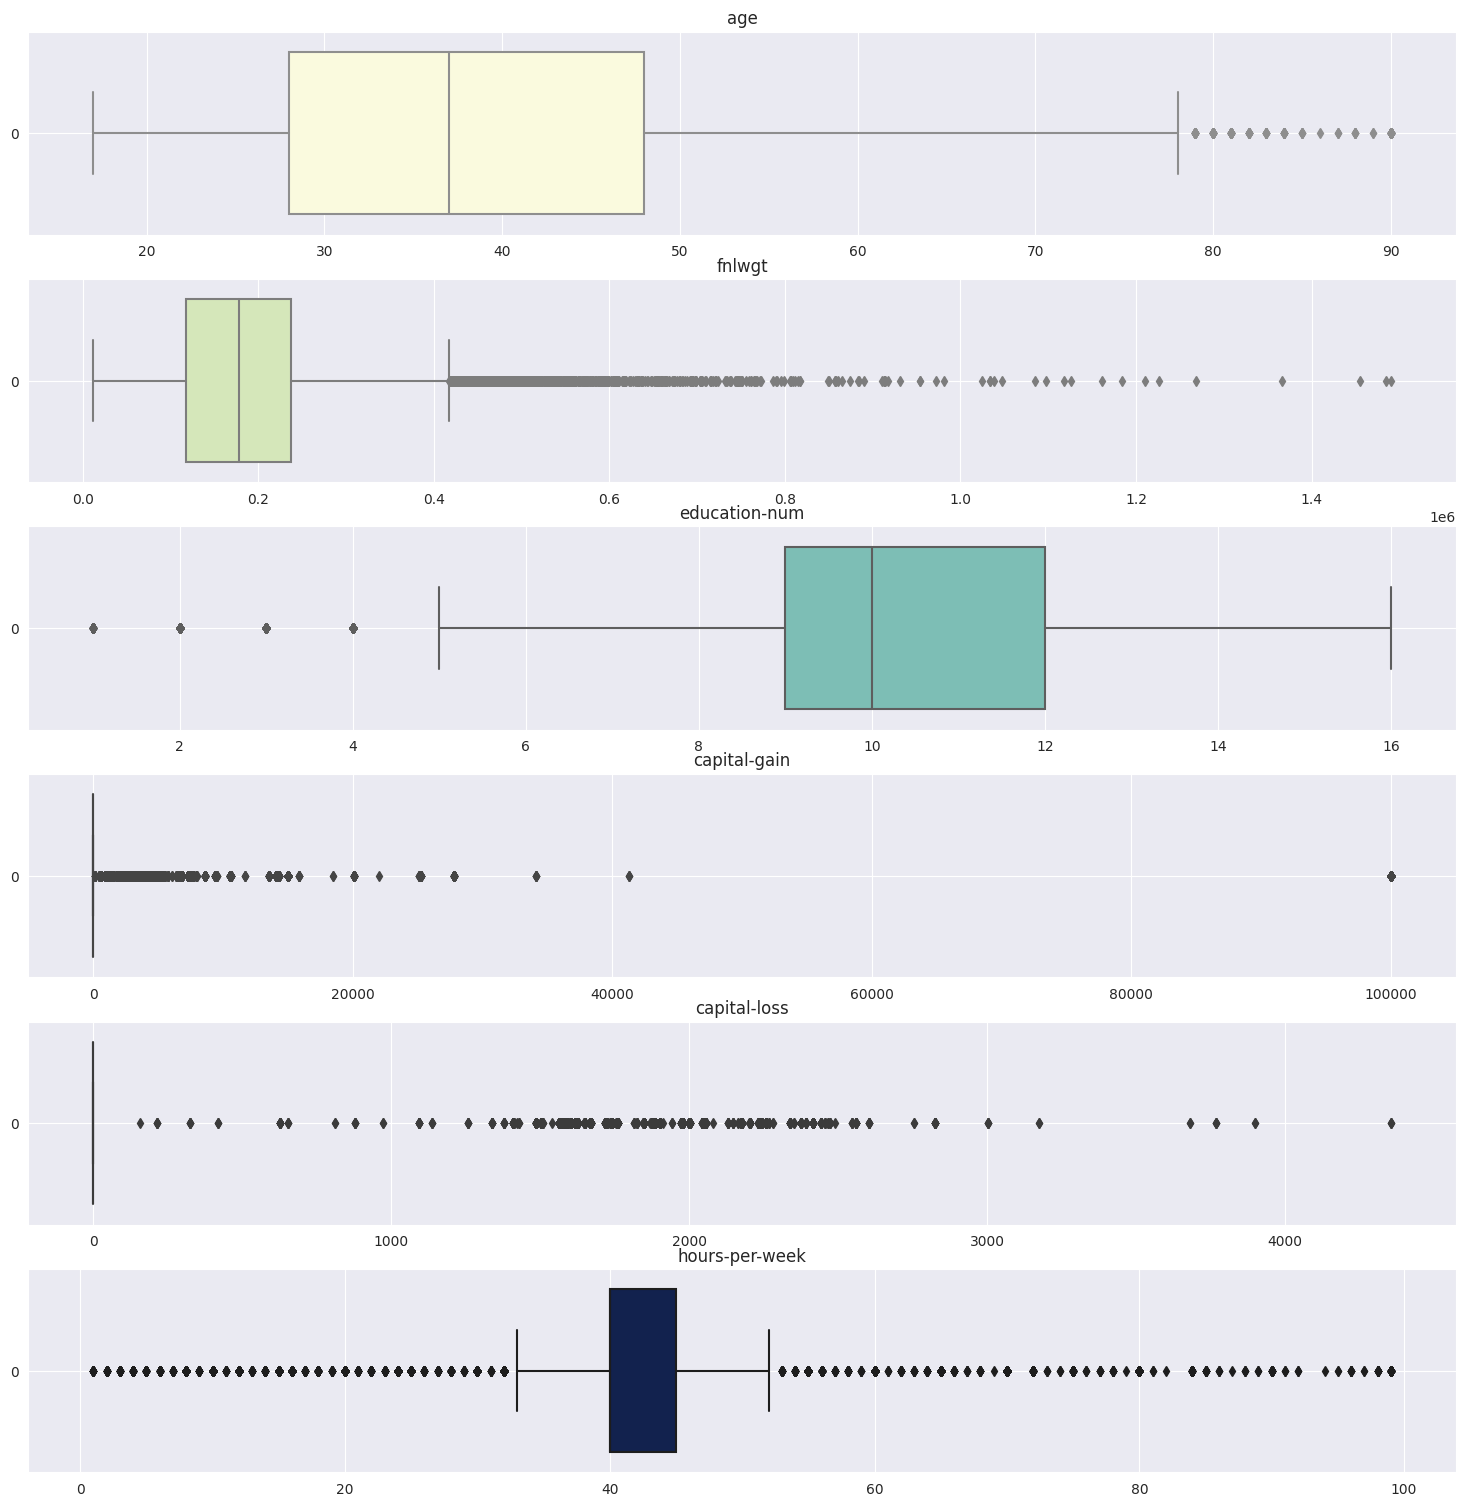

In [155]:
# numeric X visualization with Box-and-Whisker
n = len(numerical_features)

fig, axes = plt.subplots(n)
fig.set_size_inches(15, 15)
fig.tight_layout()

cmap = plt.get_cmap(CMAP)
colors = [cmap(i) for i in np.linspace(0, 1, n)]

for (ax, col, color) in zip(axes, numerical_features, colors):
    sns.boxplot(data=X[col].values, orient='h', ax=ax, color=color).set_title(col)
    ax.grid()

plt.show()

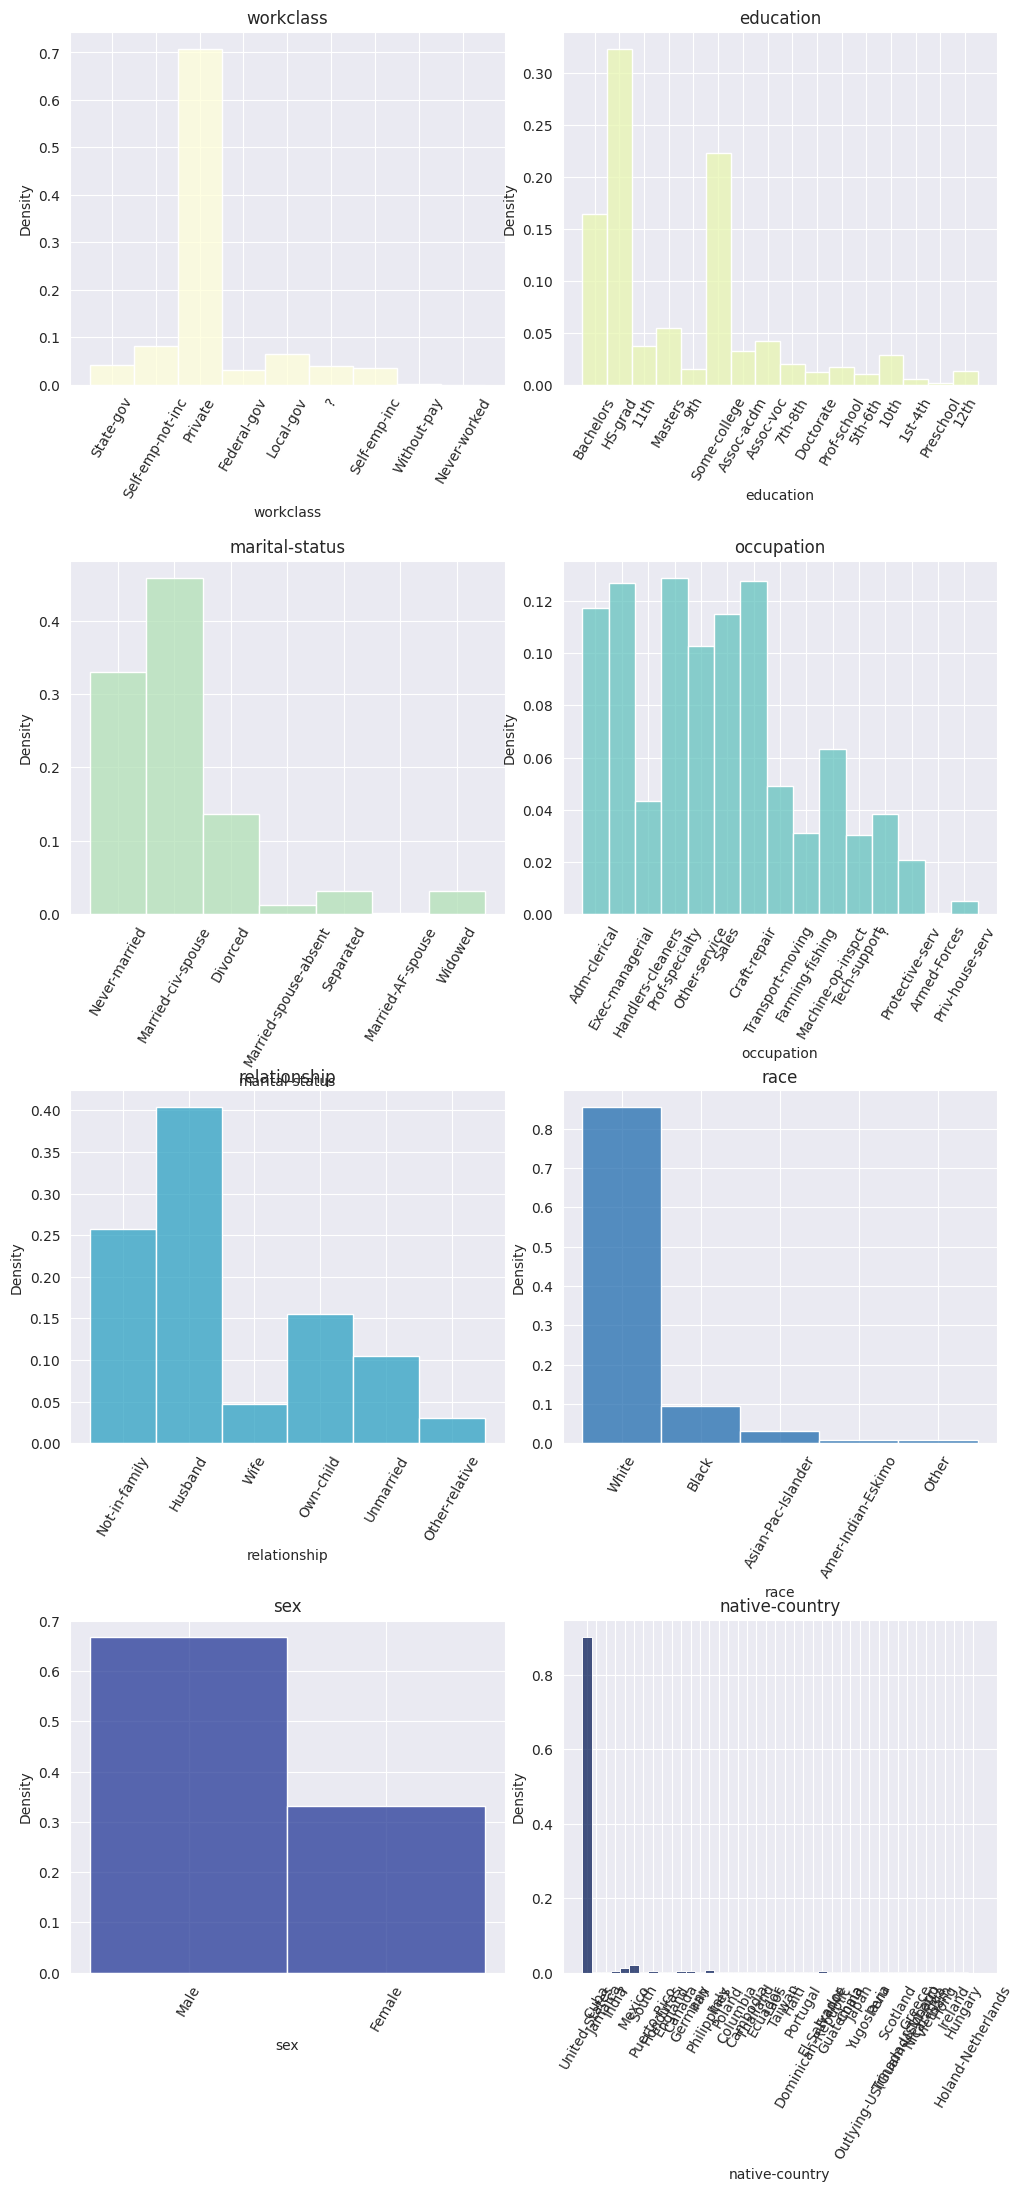

In [156]:
# hists for categorical features

m = len(categorical_features)

n_row = 4
if m % n_row != 0:
    raise ValueError("Not int")
n_col = int(m / n_row)

fig, axes = plt.subplots(n_row, n_col)
fig.set_size_inches(n_col * 5, n_row * 5)
fig.tight_layout()
plt.subplots_adjust(hspace = 0.5)

cmap = plt.get_cmap(CMAP)
colors = [cmap(i) for i in np.linspace(0, 1, m)]

for (ax, col, color) in zip(axes.flatten(), categorical_features, colors):
    sns.histplot(data=X, x=col, ax=ax, color=color, stat='density').set(title=col)
    ax.grid(True)
    ax.tick_params(axis='x', labelrotation=60)

plt.show()

In [157]:
# let's see more carefully to 'native-country' column
nc = X['native-country'].value_counts().reset_index()
nc['ttl'] = nc['count'].sum()
nc['share, %'] = 100 * nc['count'] / nc['ttl']
nc.head(1)

,native-country,count,ttl,"share, %"
0,United-States,43832,48568,90.248723


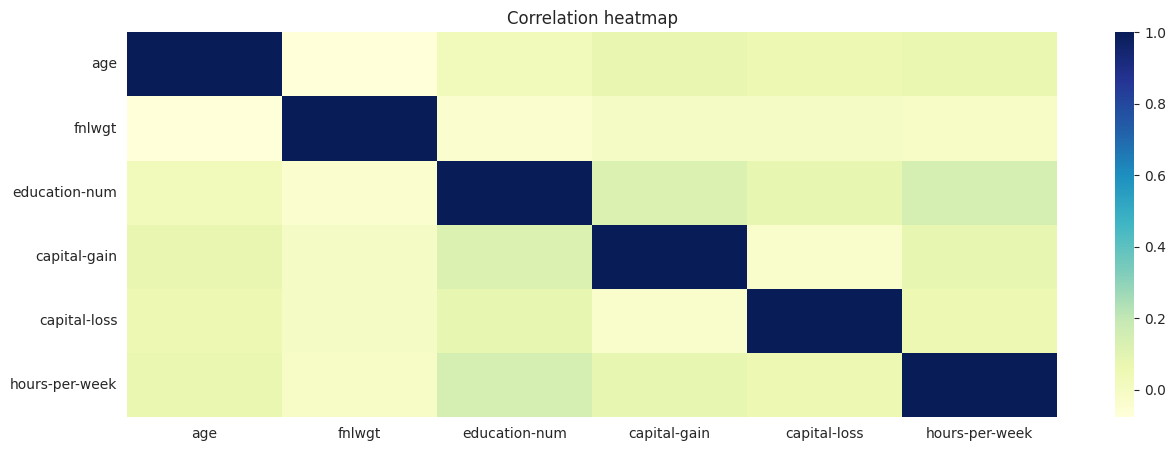

In [158]:
# correlation heatmap

fig = plt.figure(figsize=(15, 5))    
corr = X[numerical_features].corr()
sns.heatmap(corr, cmap=CMAP)
plt.title("Correlation heatmap")
plt.show()

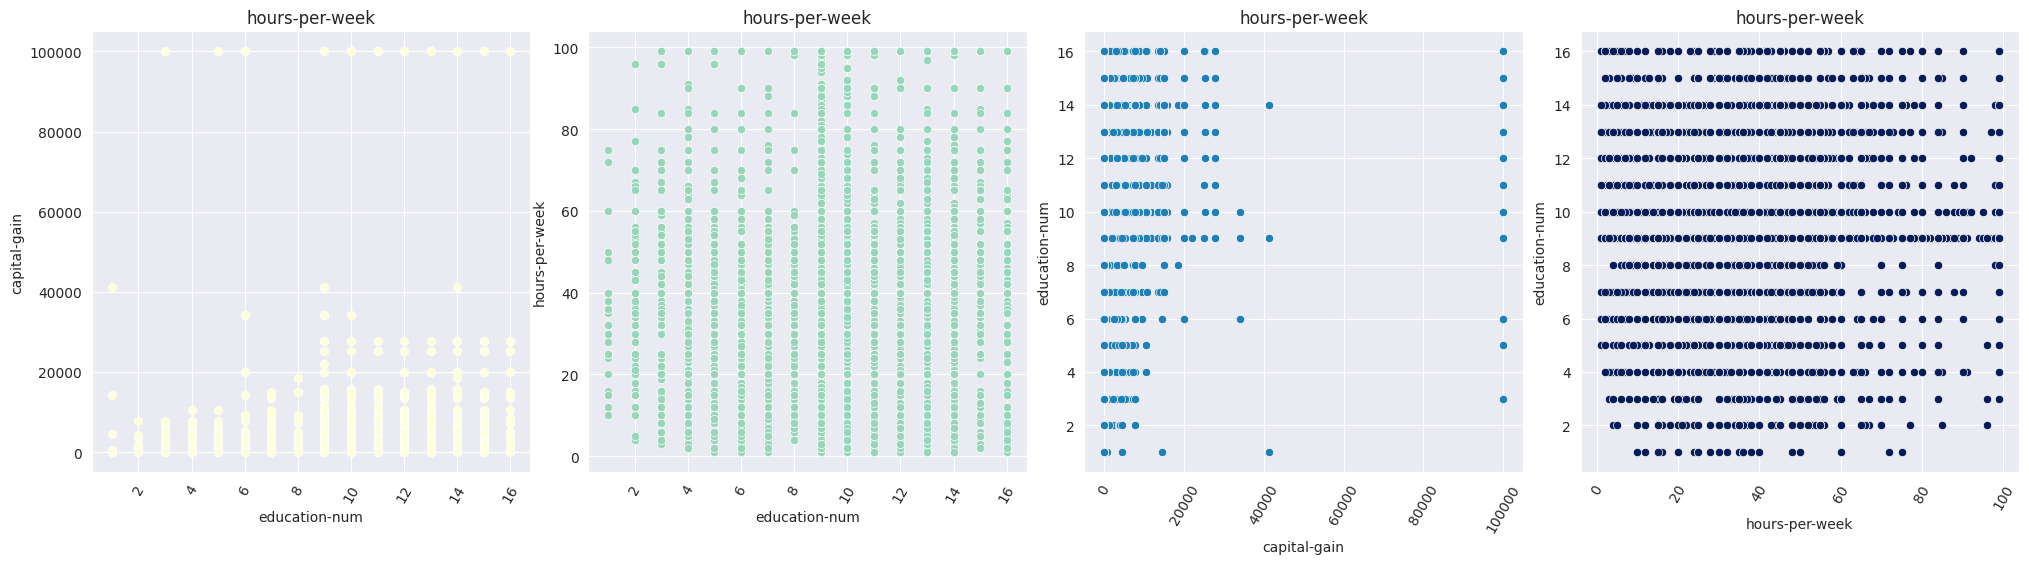

In [159]:
# scatter plot


# let's analyse only column with
# high value of correlation
to_scatter = []
for ind in corr.index:
    for col in corr.columns:
        if (np.abs(corr.loc[ind, col]) >= 0.10) & (ind != col):
            to_scatter.append((ind, col))

k = len(to_scatter)

k_row = 1
if k % k_row != 0:
    raise ValueError("Not int")
k_col = int(k / k_row)

fig, axes = plt.subplots(k_row, k_col)
fig.set_size_inches(k_col * 5, k_row * 5)
fig.tight_layout()
plt.subplots_adjust(hspace = 2.2)

cmap = plt.get_cmap(CMAP)
colors = [cmap(i) for i in np.linspace(0, 1, k)]

for (ax, cols, color) in zip(axes.flatten(), to_scatter, colors):
    sns.scatterplot(data=X, x=cols[0], y=cols[1], ax=ax, color=color).set(title=col)
    ax.grid(True)
    ax.tick_params(axis='x', labelrotation=60)

plt.show()        

In [160]:
##############################################
### Conclusion:
##############################################

# 1) Column 'workclass', 'occupation', 'native-country' have NaN values;
# 2) Column 'native-country' have more than 91% value 'United States';
# 3) Based on correlation and scatter analysis, we can say, that numerical features are not correlated.

### Prepocessing

In [161]:
# duplicated

print(f"dataset has {X.duplicated().sum()} duplicates.")
processed_X = X.drop_duplicates()

dataset has 53 duplicates.


In [162]:
# before preprocessing and normalization let's create new features
# First, diff between capital loss and capital gain
X['capital-diff'] = X['capital-gain'] - X['capital-loss']
x = X['capital-diff'].values.reshape(-1, 1)
temp = StandardScaler().fit_transform(x)
X['capital-diff'] = temp

# Second, ratio between age and education
X['edu2age'] = X['education-num'] / X['age']
x = X['edu2age'].values.reshape(-1, 1)
temp = StandardScaler().fit_transform(x)
X['edu2age'] = temp

numerical_features.extend(['capital-diff', 'edu2age'])
total_features.extend(['capital-diff', 'edu2age'])

In [163]:
# outliers + preprocessing
# https://towardsXscience.com/dont-throw-away-your-outliers-c37e1ab0ce19

############################################################################
# age. min - 17, max - 90
# All outliers are logically explained.
# We don't need to preprocess outliers, so
# let's use RobustScaler to preprocess feature.
x = X['age'].values.reshape(-1, 1)
temp = RobustScaler().fit_transform(x).flatten()
X['age'] = temp

############################################################################
# fnlwgt. min - 12285, max - 1484705
# feature - amount of people who have same other features
# https://www.kaggle.com/code/phinnik/fnlwgt
# This feature logically depends from other.
# So, it can be removed. Now we can winsorize it.
# After that, use StandardScaler
x = X['fnlwgt'].values.reshape(-1, 1)
temp = winsorize(x, [0.05, 0.05])
temp = StandardScaler().fit_transform(temp)
X['fnlwgt'] = temp

############################################################################
# education-num. min - 1, max - 16
# education-num - years of education
# All outliers are lower than lower bound
# It can be possible, because people can have 
# 1-5 years education, if they didn't end university. 
# Let's use RobustScaler to preprocess feature.
x = X['education-num'].values.reshape(-1, 1)
temp = RobustScaler().fit_transform(x).flatten()
X['education-num'] = temp

############################################################################
# capital-gain. min - 0, max - 99999
# median value - 0, max - 99999
# Strange max results and values after upper bound
# So, let's use winsorize high level to 95% percentile
# And use StandardScaler after.
x = X['capital-gain'].values.reshape(-1, 1)
temp = winsorize(x, [0, 0.05])
temp = StandardScaler().fit_transform(temp).flatten()
X['capital-gain'] = temp

############################################################################
# capital-loss. min - 0, max - 4356
# median value - 0, max - 4356
# Don't need to cut values, because there aren't
# so many values which are upper than 0
# So, use StandardScaler.
x = X['capital-loss'].values.reshape(-1, 1)
temp = StandardScaler().fit_transform(x).flatten()
X['capital-loss'] = temp

############################################################################
# hours-per-week. min - 1, max - 99
# median value - 40, max - 99
# Strange results out of box
# So, let's use winsorize.
# And StandardScaler after.
x = X['hours-per-week'].values.reshape(-1, 1)
temp = winsorize(x, [0.05, 0.05])
temp = StandardScaler().fit_transform(temp).flatten()
X['hours-per-week'] = temp

In [164]:
# missing values
# https://www.scaler.com/topics/X-science/categorical-missing-values/
# Columns 'workclass', 'occupation', 'native-country'

# columns 'workclass', 'native-country' have the most frequent values
# so, we can use imputer with mode

impute_mode = SimpleImputer(strategy = 'most_frequent')
impute_mode.fit(X[['workclass', 'native-country']])

X[['workclass', 'native-country']] = impute_mode.transform(X[['workclass', 'native-country']])

In [165]:
# Column 'occupation' has a more complex distribution
# so, we will use KNN-imputer 
# but, before using it, we need to encode categorical values

# limited count of values, so, we can use LabelEncoder
# firstly, save nan-values

original = X.copy()
mask = X.isnull()
X[categorical_features] = X[categorical_features].apply(LabelEncoder().fit_transform)
X = pd.DataFrame(np.where(mask, original, X), columns=original.columns)

In [166]:
# after all, using KNNEncoder
imputer = KNNImputer(n_neighbors = 3)
new_X = pd.DataFrame(imputer.fit_transform(X[total_features]), columns = total_features)
X = pd.concat([new_X, y[TARGET]], axis=1)
X.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
capital-diff      0
edu2age           0
income            0
dtype: int64

In [167]:
# Standard Scaler to dummy-cat features

for col in categorical_features:
    X[col] = StandardScaler().fit_transform(X[col].values.reshape(-1, 1)).flatten()

In [168]:
# output preprocessing
idx2label = list(set(X[TARGET].values))
label2idx = {k:v for v, k in enumerate(idx2label)}
X[TARGET] = X[TARGET].apply(lambda x: label2idx[x])

### Feature selection

In [170]:
# New features we created before
# numeric X preprocessing.
# We did it there, because we need to 
# use original X

from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif


X, y = X[total_features].values, X[TARGET].values

# Now, let's choose features based on k-selector
selector = SelectKBest(f_classif, k=10)
selector.fit(X, y)
print(*selector.get_feature_names_out(total_features))

X = selector.transform(X)

age education education-num marital-status relationship sex capital-gain capital-loss hours-per-week capital-diff


In [ ]:
# params


N = X.shape[0]
n_features = X.shape[1]

X_train, X_test, y_train, y_test \
    = train_test_split(X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val \
    = train_test_split(X_train, y_train, test_size=1/3, random_state=1) # 0.33 x 0.9 = 0.397

y_train = torch.Tensor(y_train.reshape(-1, 1))
X_train = torch.Tensor(X_train)
train_Xset = X_utils.TensorXset(X_train, y_train)
train_Xloader = X_utils.XLoader(train_Xset, batch_size=BATCH_SIZE, shuffle=True)

y_val = torch.Tensor(y_val.reshape(-1, 1))
X_val = torch.Tensor(X_val)
val_Xset = X_utils.TensorXset(X_val, y_val)
val_Xloader = X_utils.XLoader(val_Xset, batch_size=BATCH_SIZE, shuffle=True)

y_test = torch.Tensor(y_test.reshape(-1, 1))
X_test = torch.Tensor(X_test)
test_Xset = X_utils.TensorXset(X_test, y_test)
test_Xloader = X_utils.XLoader(test_Xset, batch_size=BATCH_SIZE, shuffle=True)

### Model architecture

In [ ]:
class PolynomialModel(torch.nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.linear1 = torch.nn.Linear(n_features, 10)
        self.activation = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(10, 10)
        self.linear3 = torch.nn.Linear(10, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.activation(x)
        x = self.sigmoid(x)
        return x
    
    def init_weights(self, type_='xavier', is_saved=False):
        if type_ == 'xavier':
            torch.nn.init.xavier_uniform(self.linear1.weight)
            self.linear1.bias.X.fill_(0.01)
            torch.nn.init.xavier_uniform(self.linear2.weight)
            self.linear2.bias.X.fill_(0.01)
            torch.nn.init.xavier_uniform(self.linear3.weight)
            self.linear3.bias.X.fill_(0.01)

In [ ]:
model = PolynomialModel(n_features)
model.init_weights(type_='xavier')

summary(model, input_size=(10, ))

In [ ]:
optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = torch.nn.BCELoss()

In [ ]:
def train_val_process(model, train_Xloader, val_Xloader, optim, loss_fn, epochs):

    for e in range(epochs):
        model.train()
        running_loss = 0.0
        last_loss = 0.0
        for i, X in enumerate(train_Xloader):
            inputs, labels = X

            if torch.cuda.is_available():
                X, labels = X.cuda(), labels.cuda()
            
            optim.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optim.step()

            running_loss += loss.item()

            if i % 10 == 9:
                last_loss = running_loss / 10
                print('  batch {} loss: {}'.format(i + 1, last_loss))
                running_loss = 0.
        
        model.eval()
        running_vloss = 0.0
        with torch.no_grad():
            for i, vX in enumerate(val_Xloader):
                vinputs, vlabels = vX
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss



     avg_vloss = running_vloss / (i + 1)
        print('Epoch {}: loss train {} valid {}'.format(e, last_loss, avg_vloss))

In [ ]:
process(train_Xloader, val_Xloader, optim, loss_fn, 20)